In [1]:
import pathlib
import shutil


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from utils import mel_features

from tqdm.notebook import tqdm
import os


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
label_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

## 下載資料集
TensorFlow Speech Command 數據集是一組一秒鐘的 .wav 音頻文件，每個文件包含一個口語英語單詞。這些詞來自一小組命令，由各種不同的說話者說出。其中 20 個詞是核心詞，10 個詞是輔助詞，可以作為算法測試忽略不包含觸發器的語音。與這 30 個單詞一起包含的是一組背景噪音音頻文件。該數據集最初是為有限詞彙量的語音識別任務而設計的。這些音頻片段最初由Google收集，並由世界各地不受控制的地點的志願者錄製。

In [3]:
# import os
# # download dataset
# os.mkdir('dataset')
# ! wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz -P dataset

In [4]:
# # extract dataset
# ! tar -xf dataset/speech_commands_v0.02.tar.gz -C dataset

In [5]:
# # define path
# data_dir = pathlib.Path('dataset')
# shutil.rmtree(data_dir.joinpath('_background_noise_')) # remove folder

## 讀取資料集

In [6]:
import glob

filenames = []
for label in label_list:
    for file in glob.glob("./dataset/"+label+"/*"):
        filenames.append(file)
filenames = np.array(filenames)
np.random.shuffle(filenames)
print(f'shape: {filenames.shape}')
filenames[:3]

shape: (38908,)


array(['./dataset/four/773e26f7_nohash_1.wav',
       './dataset/nine/2f0ce4d9_nohash_0.wav',
       './dataset/one/cce17a61_nohash_0.wav'], dtype='<U38')

## 隨機播放音檔

In [7]:
data_dir = pathlib.Path('dataset')

def decode_audio(audio_binary):                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    audio, s_rate = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)
def play_random(folder, n=10):
    files = os.listdir(data_dir.joinpath(folder))
    ch = np.random.randint(0, len(files), n)
    for i in ch:
        audio_binary = tf.io.read_file(data_dir.joinpath(folder, files[i]).as_posix())  # binary
        waveform = decode_audio(audio_binary) # decoded
        display.display(display.Audio(waveform, rate=16000))                   

In [8]:
play_random('zero', 3)

## 載入資料集

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)  # binary
    waveform = decode_audio(audio_binary) # decoded
    return waveform, label

def import_dataset(file_paths):
    waveforms = []
    labels = []
    for file_path in tqdm(file_paths):
        waveform, label = get_waveform_and_label(file_path)
        waveforms.append(waveform)
        labels.append(label)  
    return np.array(waveforms), np.array(labels)

In [10]:
X, y = import_dataset(filenames)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## 視覺化音訊
隨機從資料集中繪製一秒鐘音訊。

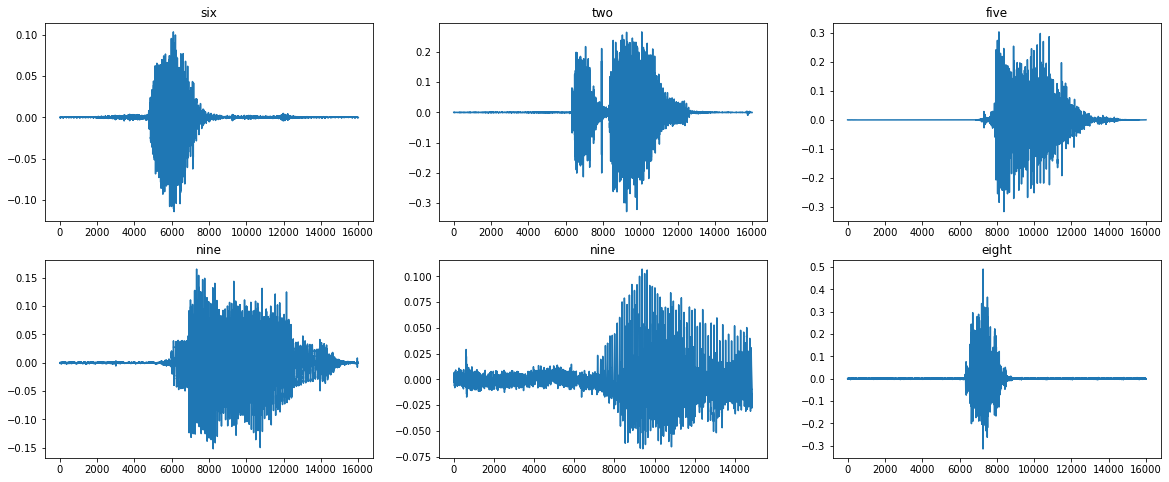

In [11]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
random_index = np.random.randint(0, len(X), n)
for i in range(n):
    audio = X[random_index[i]]
    label = y[random_index[i]]
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    label = label.numpy().decode()
    ax.set_title(label)

plt.show()

## 資料前處理
### 時頻譜 (Spectrogram)

In [12]:
def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the 
    # same length
    waveform = tf.cast(waveform, tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = equal_length.numpy().flatten()
    spectrogram = 30 * (
        mel_features.log_mel_spectrogram(
        equal_length,
            16000,
            log_offset=0.001,
            window_length_secs=0.025,
            hop_length_secs=0.010,
            num_mel_bins=32,
            lower_edge_hertz=60,
            upper_edge_hertz=3800) - np.log(1e-3))

    return spectrogram

In [13]:
def get_spectrogram_df(X, y):
    audios = []
    for audio in tqdm(X):
        spectrogram = get_spectrogram(audio)
        audios.append(spectrogram)
    return np.array(audios), y

In [14]:
X_pre, y_pre = get_spectrogram_df(X, y)

###  視覺化時頻譜

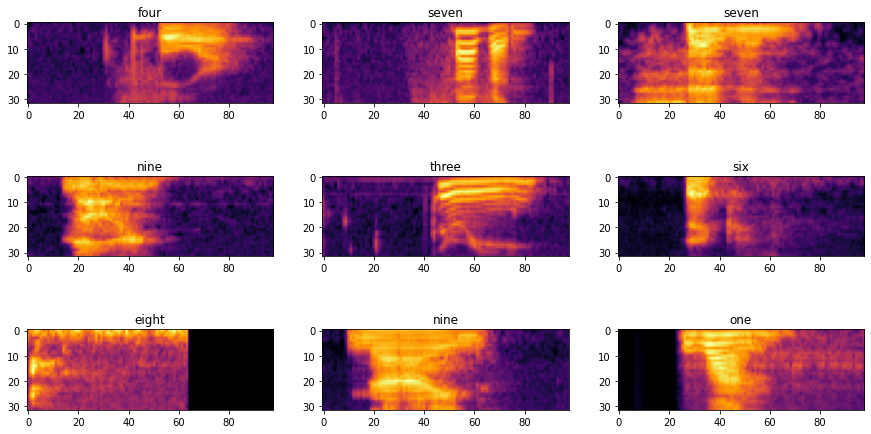

In [30]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
random_index = np.random.randint(0, len(X_pre), n)
for i in range(rows*cols):
    audio = X_pre[random_index[i]]
    label = y_pre[random_index[i]]
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.imshow(audio.T, cmap="inferno")
    ax.set_title(label.numpy().decode())

### One-hot encoding

In [34]:
y_enc = np.array([label_list.index(l) for l in y_pre])
y_enc = tf.one_hot(y_enc, len(label_list))

(38908, 10)


## 切割訓練集測試集

In [39]:
def train_test_split(X, y, test_size):
    n_test = int(X.shape[0] * test_size)
    X_test = X[:n_test]
    y_test = y[:n_test]
    X_train = X[n_test:]
    y_train = y[n_test:]
    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_enc, 0.1)

In [41]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(35018, 98, 32) (35018, 10)
(3890, 98, 32) (3890, 10)


## 標準化

In [43]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_norm = X_train-mean # x_train = x_train - mean
X_train_norm = X_train/std

X_test_norm = X_test-mean
X_test_norm = X_test/std

y_train_norm = y_train
y_test_norm = y_test

print(X_train_norm.shape, y_train_norm.shape)
print(X_test_norm.shape, y_test_norm.shape)

(35018, 98, 32) (35018, 10)
(3890, 98, 32) (3890, 10)


In [44]:
# # 輸出正規化參數
np.savetxt(r'./data/mean.txt', mean.flatten(), fmt='%f')
np.savetxt(r'./data/std.txt', std.flatten(), fmt='%f')

## Build KWT Model

In [46]:
from utils.transformer import TransformerEncoder, PatchClassEmbedding
from utils.tools import CustomSchedule

In [47]:
# model configurations
d_model = 64
d_ff = d_model * 2
n_heads = 1
mlp_head_size = 256
dropout = 0.1
activation = tf.nn.relu #gelu
n_layers = 12

In [48]:
def build_kwt(transformer, input_size):
    # Input
    inputs = tf.keras.layers.Input(shape=input_size)
    
    # Linear Projection of Flattened Patches
    x = tf.keras.layers.Dense(d_model)(inputs)
    
    # Position Embedding + Extra learnable class embedding
    x = PatchClassEmbedding(d_model, input_size[0])(x)
    
    # Transformer Model
    x = transformer(x)
    
    # Take only the Extra Learnable Class
    x = tf.keras.layers.Lambda(lambda x: x[:,0,:])(x)
    
    # MLP Head
    x = tf.keras.layers.Dense(mlp_head_size)(x)
    outputs = tf.keras.layers.Dense(len(label_list), activation='softmax')(x)
    
    return tf.keras.models.Model(inputs, outputs)


In [55]:
transformer = TransformerEncoder(d_model, n_heads, d_ff, dropout, activation, n_layers)
model = build_kwt(transformer, input_size=X_train_norm.shape[1:])

In [56]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 98, 32)]          0         
_________________________________________________________________
dense_220 (Dense)            (None, 98, 64)            2112      
_________________________________________________________________
patch_class_embedding_2 (Pat (None, 99, 64)            6400      
_________________________________________________________________
transformer_encoder_2 (Trans (None, 99, 64)            401664    
_________________________________________________________________
lambda_1 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_221 (Dense)            (None, 256)               16640     
_________________________________________________________________
dense_222 (Dense)            (None, 10)               

## Train the Model

In [58]:
# set some variables
batch_size = 64
n_epochs = 15

In [59]:
lr = CustomSchedule(d_model, warmup_steps=20000.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy'])

In [60]:
history = model.fit(
    X_train_norm, y_train_norm, 
    validation_data=(X_test_norm, y_test_norm),  
    epochs=n_epochs, initial_epoch=0)

Epoch 1/15
1095/1095 [==============================] - 170s 155ms/step - loss: 2.0177 - accuracy: 0.2793 - val_loss: 1.8955 - val_accuracy: 0.3522
Epoch 2/15
1095/1095 [==============================] - 166s 151ms/step - loss: 1.5838 - accuracy: 0.4888 - val_loss: 1.4047 - val_accuracy: 0.5812
Epoch 3/15
1095/1095 [==============================] - 163s 149ms/step - loss: 1.2982 - accuracy: 0.6453 - val_loss: 1.1498 - val_accuracy: 0.7280
Epoch 4/15
1095/1095 [==============================] - 162s 148ms/step - loss: 1.0553 - accuracy: 0.7651 - val_loss: 0.9616 - val_accuracy: 0.8098
Epoch 5/15
1095/1095 [==============================] - 161s 147ms/step - loss: 0.9321 - accuracy: 0.8203 - val_loss: 0.8877 - val_accuracy: 0.8452
Epoch 6/15
1095/1095 [==============================] - 161s 147ms/step - loss: 0.8728 - accuracy: 0.8464 - val_loss: 0.9070 - val_accuracy: 0.8324
Epoch 7/15
1095/1095 [==============================] - 161s 147ms/step - loss: 0.8428 - accuracy: 0.8591 - val_

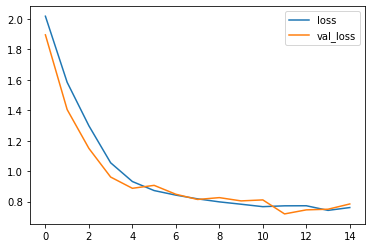

In [61]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Test the model

In [62]:
model.evaluate(X_test, y_test)

122/122 [==============================] - 6s 50ms/step - loss: 1.1516 - accuracy: 0.7663


[1.1516116857528687, 0.7663239240646362]

## Convert to ONNNX

In [63]:
import tf2onnx
import onnx

onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "./data/tf_model.onnx")

In [64]:
import pandas as pd

mean = pd.read_csv("./data/mean.txt", sep=" ", header=None).values.reshape(98, 32, 1)
std = pd.read_csv("./data/std.txt", sep=" ", header=None).values.reshape(98, 32, 1)

In [65]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt

sess = rt.InferenceSession("./tf_model.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: np.array([X_test_norm[0].squeeze()]).astype(np.float32)})[0]
print(f'Predict: {pred_onx.argmax(axis=1)}, Ground True: {y_test_norm[0].numpy().argmax()}')

Predict: [4], Ground True: 4


### 驗證
- 16KHz 1秒鐘音訊
- 音訊的輸入維度 (98, 32)

In [158]:
import wave
import numpy as np


spf = wave.open("./data/9-1.wav", "r")
# spf = wave.open("./dataset/yes/10467b06_nohash_0.wav", "r")
# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "int16")
signal=signal
signal.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


(13375,)

In [159]:
# scale to -1~1
MIN=-32768
MAX=32767;
input_speech=[]
for i in range(len(signal)):
    X_std = (signal[i] - MIN)*1. / (MAX - MIN)
    X_std = X_std * (1 - -1) + -1
    input_speech.append(X_std)

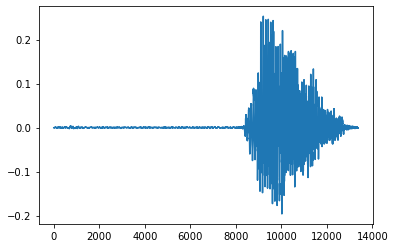

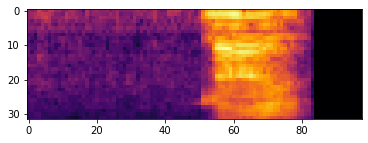

In [161]:
data = get_spectrogram(input_speech)[..., np.newaxis]
data -= -mean
data /= std
data = data.squeeze()

# inference
pred_onx = sess.run([label_name], {input_name: np.array([data]).astype(np.float32)})[0]
label_list[pred_onx.argmax()]

'nine'